# Analyze raw AIS data

## Purpose
* The SSPA AIS DB contain some vectorizing with data reduction.
* Comparing SSPA AIS DB with GPS data has shown 2-6% difference in distance.
* This notebook will explore raw AIS data without the data reduction.

## Methodology
* Load raw AIS data
* Load GPS data
* compare time stamps.

## Setup

In [1]:
# %load imports.py
from typing import no_type_check
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from pyaisdb.database import DB



In [2]:
from shapely.geometry import Point

In [3]:
db = DB()

The analysis will be carried out between the following dates and for a ship with MMSI number as below:

In [4]:
date1 = '2020-07-10 00:00:00+02'
date2 = '2020-07-19 23:59:59+02'
mmsi = 265520390
sog_min = 1

## AIS data
Loading data from SSPA AIS DB. In this DB the AIS data has been transformed into segments including some data reduction including.

In [29]:
sql = f"""select * 
  FROM ais_plugin.d2e2f_265520390
	where date_time < '{date2}'
                  and date_time > '{date1}'
and sog >= {sog_min}"""
df_ais = gpd.GeoDataFrame.from_postgis(sql, db.conn, geom_col='pos', index_col='date_time', crs='EPSG:4326') 
df_ais.sort_index(inplace=True)

In [30]:
df_ais.describe()

,mmsi,imo_nr,type_and_cargo,lat,lon,cog,sog,heading
count,71215.0,71215.0,71215.0,71215.000000,71215.000000,71215.000000,71215.000000,71215.000000
mean,265520390.0,0.0,60.0,59.407290,18.504328,173.778549,13.095383,175.110876
std,0.0,0.0,0.0,0.048353,0.235827,101.505865,5.389642,101.399094
min,265520390.0,0.0,60.0,59.317186,18.074175,0.000000,1.000000,0.000000
25%,265520390.0,0.0,60.0,59.376620,18.330952,77.599998,8.700000,79.000000
50%,265520390.0,0.0,60.0,59.409710,18.503789,188.800003,12.500000,192.000000
75%,265520390.0,0.0,60.0,59.439879,18.704586,258.500000,18.799999,260.000000
max,265520390.0,0.0,60.0,59.501947,18.933004,359.899994,22.299999,359.000000


In [31]:
df_ais.head()

,mmsi,imo_nr,type_and_cargo,lat,lon,pos,cog,sog,heading
date_time,,,,,,,,,
2020-07-10 04:39:25+00:00,265520390,0,60,59.501805,18.843978,POINT (18.84398 59.50180),165.699997,2.1,338.0
2020-07-10 04:39:35+00:00,265520390,0,60,59.501729,18.844187,POINT (18.84419 59.50173),150.800003,3.2,327.0
2020-07-10 04:39:37+00:00,265520390,0,60,59.501608,18.844166,POINT (18.84417 59.50161),142.399994,3.4,324.0
2020-07-10 04:39:42+00:00,265520390,0,60,59.501638,18.844250,POINT (18.84425 59.50164),140.000000,3.6,320.0
2020-07-10 04:39:45+00:00,265520390,0,60,59.501524,18.844288,POINT (18.84429 59.50152),136.199997,3.7,318.0


## Projection : WGS84

Text(14.375, 0.5, 'lon [deg]')

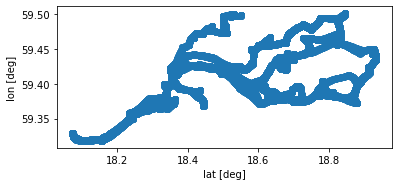

In [61]:
fig,ax=plt.subplots()
df_ais.plot(ax=ax)
ax.set_xlabel('lat [deg]')
ax.set_ylabel('lon [deg]')

### Projection: EPSG:3152

In [35]:
df_ais_m = df_ais.to_crs('EPSG:3152')

Text(11.5, 0.5, 'y [m]')

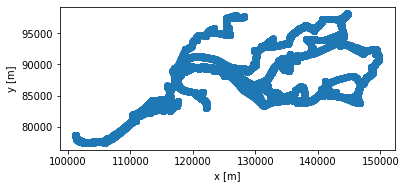

In [62]:
fig,ax=plt.subplots()
df_ais_m.plot(ax=ax)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

In [54]:
df_ais['distance_proj'] = df_ais_m.distance(df_ais_m.shift())

In [55]:
df_ais['distance_proj'].sum()

2080603.6681805123

### Great circle distance

In [56]:
import pyproj

geod = pyproj.Geod(ellps='WGS84')

lat0=df_ais.lat
lon0=df_ais.lon

lat1=df_ais.shift().lat 
lon1=df_ais.shift().lon
    
azimuth1, azimuth2, distance = geod.inv(lon0, lat0, lon1, lat1)
df_ais['distance_great_circle'] = distance

In [63]:
df_ais['distance_great_circle'].sum()

2080596.416292648

In [58]:
df_ais['distance_proj'].sum() / df_ais['distance_great_circle'].sum()

1.000003485485127

## GPS data
Loading the GPS data, which is given as points, the Lat/Lon position of the ship.

In [41]:
sql = f"""select * 
  FROM projects._49145341_d2e2f_blue_data_varmdo
	where time_info < '{date2}'
                  and time_info > '{date1}'
and sog >= {sog_min}"""
df_gps = gpd.GeoDataFrame.from_postgis(sql, db.conn, geom_col='pos', index_col='time_info', crs='EPSG:4326') 
df_gps.sort_index(inplace=True)
assert df_gps.index.is_unique

In [22]:
df_gps.describe()

,row_id,sog,t
count,3.198810e+05,319881.000000,319881.000000
mean,1.224438e+06,12.425776,422871.686893
std,2.484101e+05,5.423208,248410.088086
min,8.015660e+05,1.000000,0.000000
25%,1.011486e+06,8.600000,209920.000000
50%,1.237274e+06,12.300000,435708.000000
75%,1.432415e+06,18.000000,630849.000000
max,1.628477e+06,22.200000,826911.000000


In [23]:
df_gps.head()

,row_id,sog,pos,t
time_info,,,,
2020-07-10 04:39:25+00:00,801566,1.3,POINT (18.84408 59.50184),0.0
2020-07-10 04:39:26+00:00,801567,1.4,POINT (18.84408 59.50183),1.0
2020-07-10 04:39:27+00:00,801568,1.4,POINT (18.84409 59.50182),2.0
2020-07-10 04:39:28+00:00,801569,1.5,POINT (18.84409 59.50182),3.0
2020-07-10 04:39:29+00:00,801570,1.6,POINT (18.84410 59.50180),4.0


In [42]:
df_gps_m = df_gps.to_crs('EPSG:3152')

<AxesSubplot:>

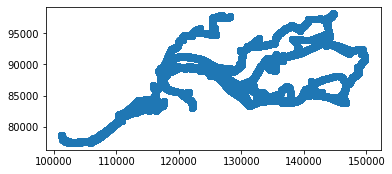

In [43]:
df_gps_m.plot()

In [44]:
df_gps_m['distance'] = df_gps_m.distance(df_gps_m.shift())

In [45]:
df_gps_m['distance'].sum()

2056800.3824275045

In [46]:
df_gps_m['distance'].sum() / df_ais_m['distance'].sum()

0.9885594329583088

## Compare GPS and AIS

### Compare trajectories

Plot of the AIS and GPS points:

<AxesSubplot:>

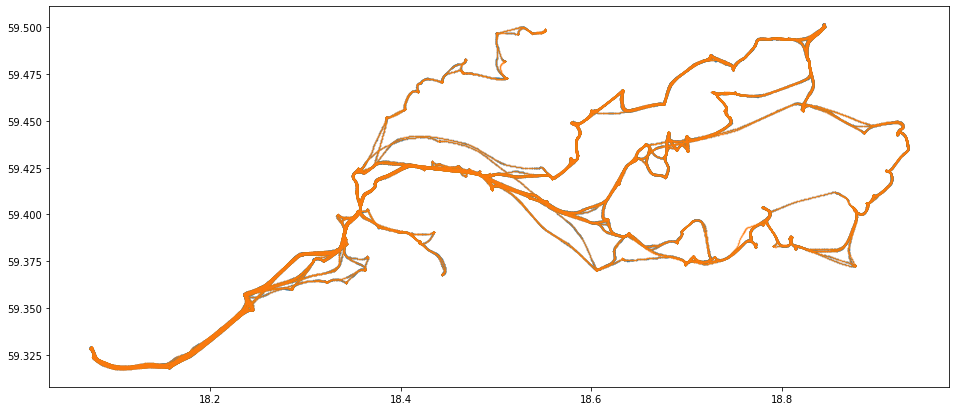

In [14]:
fig,ax=plt.subplots()
fig.set_size_inches(17,7)
df_ais.plot(markersize=0.2, label='AIS', ax=ax)
df_gps.plot(markersize=0.2, label='GPS', ax=ax, alpha=0.2)

In [24]:
def point_to_lat_lon(df, geometry_column='pos'):
    
    df_lat_lon = pd.DataFrame(index=df.index)
    df_lat_lon['longitude'] = df[geometry_column].apply(lambda p: p.x)
    df_lat_lon['latitude'] = df[geometry_column].apply(lambda p: p.y)
    
    return df_lat_lon

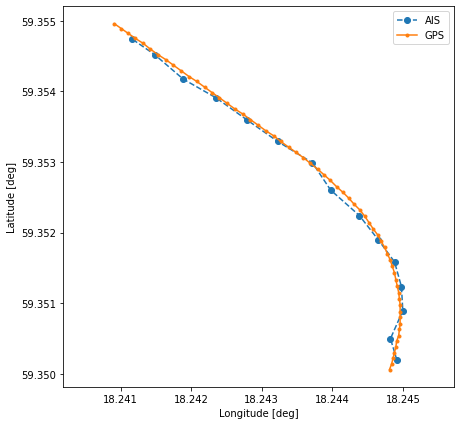

In [26]:
start_ = "2020-07-10 10:02:00+00:00"
stop_ = "2020-07-10 10:03:00+00:00"
mask = ((df_ais.index >= start_) &
        (df_ais.index <= stop_)
       )   
df_lat_lon_ais = point_to_lat_lon(df=df_ais.loc[mask])


mask = ((df_gps.index >= start_) &
        (df_gps.index <= stop_)
       )   
df_lat_lon_gps = point_to_lat_lon(df=df_gps.loc[mask])

fig,ax=plt.subplots()
fig.set_size_inches(7,7)
df_lat_lon_ais.plot(x='longitude', y='latitude', style='o--', label='AIS', ax=ax)
df_lat_lon_gps.plot(x='longitude', y='latitude', style='.-', label='GPS', ax=ax)

ax.axis('equal');
ax.legend()
ax.set_ylabel('Latitude [deg]');
ax.set_xlabel('Longitude [deg]');
ax.ticklabel_format(useOffset=False, style='plain')

### Compare time series
There could be data missing in either the AIS or GPS data, due to problems in the data collection. The time series are compared below to check that this is not the case.

#### Cutting the same time window for AIS and GPS

In [15]:
start = np.max([df_gps.index[0], df_ais.index[0]])
stop = np.min([df_gps.index[-1], df_ais.index[-1]])
mask = ((df_gps.index >=start) & (df_gps.index<=stop))
df_gps = df_gps.loc[mask].copy()

mask = ((df_ais.index >=start) & (df_ais.index<=stop))
df_ais = df_ais.loc[mask].copy()

In [16]:
df_gps['t'] = (df_gps.index-df_gps.index[0]).total_seconds().values
df_ais['t'] = (df_ais.index-df_gps.index[0]).total_seconds().values  # Note that t0 is taken from GPS

In [17]:
df_ais['t']

date_time
2020-07-10 04:39:25+00:00         0.0
2020-07-10 04:39:35+00:00        10.0
2020-07-10 04:39:37+00:00        12.0
2020-07-10 04:39:42+00:00        17.0
2020-07-10 04:39:45+00:00        20.0
                               ...   
2020-07-19 18:21:00+00:00    826895.0
2020-07-19 18:21:06+00:00    826901.0
2020-07-19 18:21:10+00:00    826905.0
2020-07-19 18:21:12+00:00    826907.0
2020-07-19 18:21:16+00:00    826911.0
Name: t, Length: 71215, dtype: float64

From a visual inspection it seems that both AIS and GPS have data for the same times:

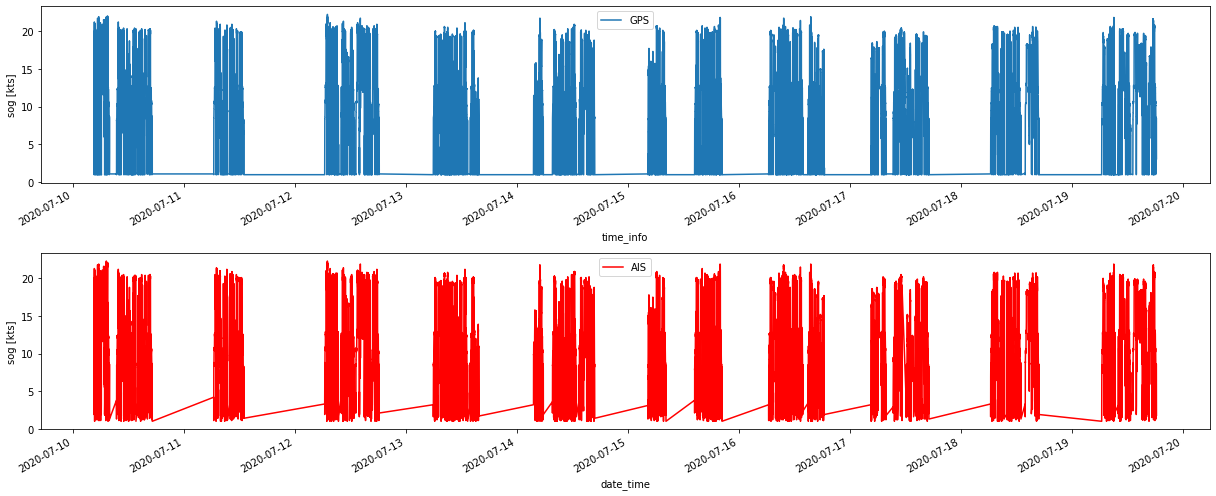

In [18]:
fig,axes=plt.subplots(nrows=2)
fig.set_size_inches(17,7)
df_gps.plot(y='sog', kind='line', ax=axes[0], label='GPS')
df_ais.plot(y='sog', kind='line', ax=axes[1], label='AIS', style='r-')
axes[0].set_ylabel('sog [kts]');
axes[1].set_ylabel('sog [kts]');
plt.tight_layout()



### Compare speed over ground

Zooming in on a couple of hours of the **sog** time series, it seems that there are small deviations between the AIS and GPS.

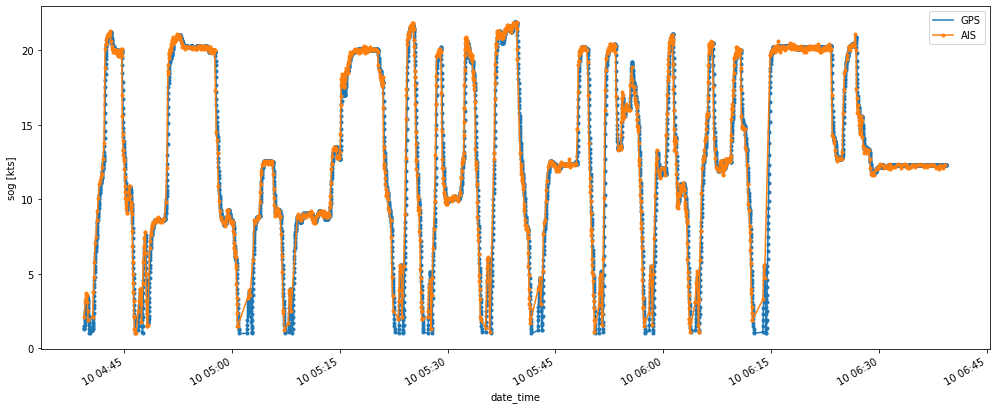

In [19]:
fig,ax=plt.subplots()
fig.set_size_inches(17,7)

stop_date = '2020-07-10 06:39:25+00:00'
mask = df_gps.index < stop_date
df_gps_cut = df_gps.loc[mask].copy()

mask = df_ais.index < stop_date
df_ais_pos_cut = df_ais.loc[mask].copy()


#df_gps_cut.resample('30S').mean().dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='GPS')
#df_ais_pos_cut.resample('30S').mean().dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='AIS')

df_gps_cut.dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='GPS')
df_ais_pos_cut.dropna().plot(y='sog', kind='line', style='.-', ax=ax, label='AIS');
ax.set_ylabel('sog [kts]');

In [20]:
df_gps.describe()

,row_id,sog,t
count,3.198810e+05,319881.000000,319881.000000
mean,1.224438e+06,12.425776,422871.686893
std,2.484101e+05,5.423208,248410.088086
min,8.015660e+05,1.000000,0.000000
25%,1.011486e+06,8.600000,209920.000000
50%,1.237274e+06,12.300000,435708.000000
75%,1.432415e+06,18.000000,630849.000000
max,1.628477e+06,22.200000,826911.000000


In [21]:
df_ais.describe()

,mmsi,imo_nr,type_and_cargo,lat,lon,cog,sog,heading,t
count,71215.0,71215.0,71215.0,71215.000000,71215.000000,71215.000000,71215.000000,71215.000000,71215.000000
mean,265520390.0,0.0,60.0,59.407290,18.504328,173.778549,13.095383,175.110876,411524.534873
std,0.0,0.0,0.0,0.048353,0.235827,101.505865,5.389642,101.399094,249425.785339
min,265520390.0,0.0,60.0,59.317186,18.074175,0.000000,1.000000,0.000000,0.000000
25%,265520390.0,0.0,60.0,59.376620,18.330952,77.599998,8.700000,79.000000,205122.000000
50%,265520390.0,0.0,60.0,59.409710,18.503789,188.800003,12.500000,192.000000,388588.000000
75%,265520390.0,0.0,60.0,59.439879,18.704586,258.500000,18.799999,260.000000,623639.000000
max,265520390.0,0.0,60.0,59.501947,18.933004,359.899994,22.299999,359.000000,826911.000000
